# Function classifier

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

202989386


In [4]:
class config:
    MODEL_HIDDEN_DIM = 64

    # Embedder model
    N_SAMPLES = 32
    EPOCHS = 200

## Generals

In [5]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def generate_X(size):
    return np.random.rand(size) * 2 - 1


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)

## Data

In [6]:
mdf = pd.read_pickle("models/fourier_models.pkl")

In [7]:
mdf = mdf.loc[mdf.valid_loss < 2.5].reset_index(drop=True)
mdf.groupby("func")["func"].count()

func
0    47
1    50
2    50
3    46
4    38
5    50
6    50
7    45
8    50
9    49
Name: func, dtype: int64

In [93]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(self, df: pd.DataFrame, n_samples: int = 10):
        self.df = df.reset_index(drop=True)
        self.n_samples = n_samples

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        model = get_model()
        model.load_state_dict(row["model"])
        for param in model.parameters():
            param.requires_grad = False
        X = torch.as_tensor(generate_X(self.n_samples)).float()
        X = torch.sort(X)[0][:, None]
        X.requires_grad_(True)
        out = model(X)
        loss = out.mean()
        loss.backward()
        input_grads = X.grad.clone().detach()
        x = torch.cat([X, input_grads], dim=1).flatten().detach()
        y = torch.tensor(row["func"])
        return x, y

In [94]:
from sklearn.model_selection import train_test_split

train_idxs, valid_idxs = train_test_split(mdf.index, test_size=0.2, stratify=mdf["func"])
mdf["valid"] = False
mdf.loc[valid_idxs, "valid"] = True

mdf.groupby("func")["valid"].value_counts()

func  valid
0     False    38
      True      9
1     False    40
      True     10
2     False    40
      True     10
3     False    37
      True      9
4     False    30
      True      8
5     False    40
      True     10
6     False    40
      True     10
7     False    36
      True      9
8     False    40
      True     10
9     False    39
      True     10
Name: count, dtype: int64

In [97]:
train_ds = GradientDataset(mdf.loc[~mdf["valid"]], n_samples=config.N_SAMPLES)
valid_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES)

len(train_ds), len(valid_ds)

(380, 95)

In [98]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 64]), torch.Size([64]))

## Train

In [99]:
from torch.optim.lr_scheduler import OneCycleLR

model = Net(input_dim=64, hidden_dim=64, output_dim=10)
optimiser = Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-2, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            valid_loss += loss_func(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

In [102]:
# torch.save(model.state_dict(), "models/grad_classifier.pth")

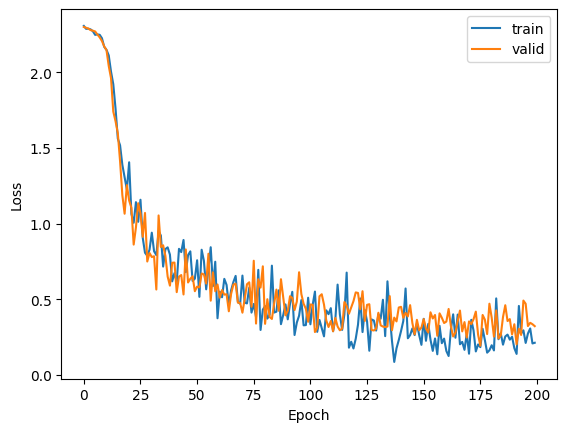

In [103]:
from physics_mi.eval import plot_loss

plot_loss(log["train_loss"], log["valid_loss"])

In [110]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb)
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds)
    y_preds = torch.softmax(y_preds, dim=1).argmax(dim=1).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X


def accuracy(y_preds, y_targs):
    return (y_preds == y_targs).mean()

In [108]:
y_preds, y_targs, X = get_preds(model, valid_dl)

In [111]:
accuracy(y_preds, y_targs)

0.9368421052631579

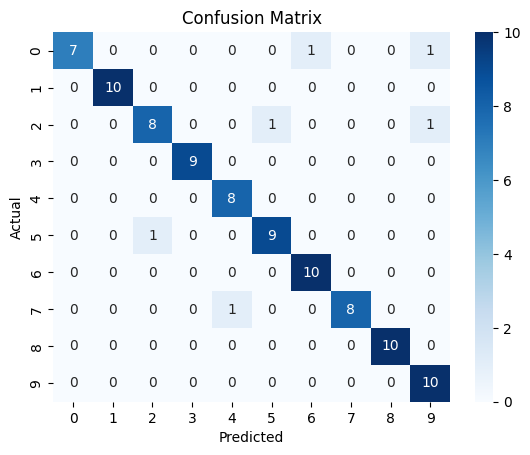

In [113]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_targs, y_preds)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Ok that was straightforward.

To be honest, this seems extremely trivial. I can _see_ that the gradients are distinct (and therefore classifiable) between each function, so being able to train a classifier on it is no surprise. _Now_ it's just a case of training something _unsupervised_ to pull out the same information 🤔.

One potential issue I forsee is what happens when your input space becomes loads larger. Obviously 1D is fine because we can sample densely. I'd imagine for high dimensional input spaces we'd just need bigger models...